# Checking in on how the 96 member historical run is tracking

In [1]:
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib
fs = 12
font = {'weight' : 'normal',
        'size'   : fs}
matplotlib.rc('font', **font)

In [3]:
path = '/g/data/xv83/ds0092/CAFE/historical/WIP/c5-d60-pX-hist-19601101-96mem'
ensembles = 96

# Ocean scalar

In [17]:
def reduced_dt_sections(mom_outs):
    mom_outs = ['.0_months_done']+[mom_out for mom_out in mom_outs if '_months_done' in mom_out]
    sorted_mom_outs = sorted(mom_outs, key=lambda x: int(x.rpartition('_months_done')[0].split('.')[-1]))
    reduced = []
    for i in range(len(sorted_mom_outs)):
        if 'o900' in sorted_mom_outs[i]:
            i_start = int(sorted_mom_outs[i-1].rpartition('_months_done')[0].split('.')[-1])
            i_end = int(sorted_mom_outs[i].rpartition('_months_done')[0].split('.')[-1])
            reduced.append((i_start,i_end))
    return reduced

In [5]:
variable = 'temp_total'
being_rerun = [20, 31, 37, 54]

ds = []
for mem in range(1, ensembles+1):
    files = sorted(glob.glob(f'{path}/mem{str(mem).zfill(3)}/ocean_scalar*.nc'))[:-1]
    if mem in being_rerun:
        files = files[:-4]
    ds.append(xr.open_mfdataset(files)[variable].assign_coords({'ensemble': mem}).compute())
ds = xr.concat(ds, dim='ensemble')

In [6]:
# clim_period = slice('1980','1999')
# clim = ds.sel(time=clim_period).mean('ensemble').groupby('time.month').mean('time')

# ds_anom = ds.groupby('time.month') - clim
ds_anom = ds

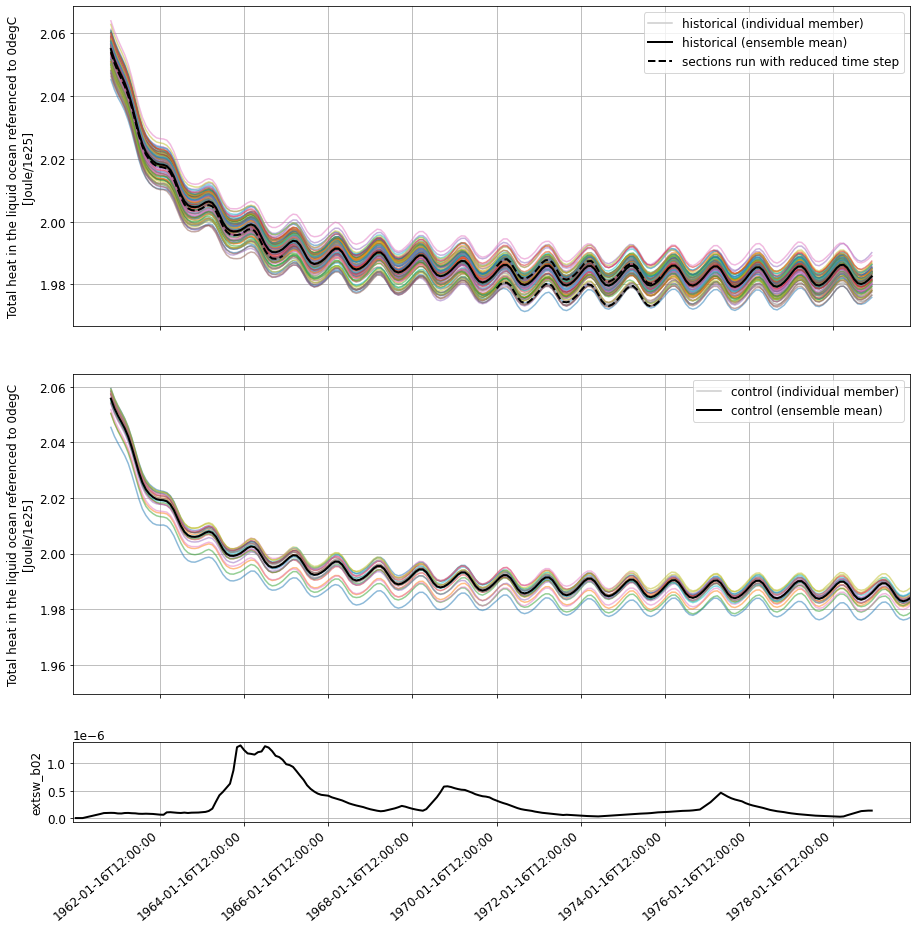

In [37]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [4, 4, 1]}, figsize=(15,15))

# ====================================================================
plot_ensembles = ds_anom.ensemble.values
for idx, e in enumerate(plot_ensembles):
    ax0.plot([np.datetime64(t.strftime()) for t in ds_anom.time.values], 
         ds_anom.sel(ensemble=e), 
         label='__nolabel__', 
         linewidth=1.5, alpha=0.5)
    
for idx, e in enumerate(plot_ensembles):
    mom_outs = glob.glob(f'{path}/mem{str(e).zfill(3)}/mom*')
    sections = reduced_dt_sections(mom_outs)
    if sections is not []:
        for section in sections:
            ax0.plot([np.datetime64(t.strftime()) for t in ds_anom.time.values[section[0]:section[1]]], 
                     ds_anom.sel(ensemble=e)[section[0]:section[1]], 
                     color='k', linestyle='--', linewidth=2,
                     label='__nolabel__')
ax0.plot([np.nan, np.nan], [np.nan, np.nan], 
         color=[0.8,0.8,0.8], label='historical (individual member)')

ax0.plot([np.datetime64(t.strftime()) for t in ds_anom.time.values], 
         ds_anom.mean('ensemble'), 
         label='historical (ensemble mean)', color='k', linewidth=2)

ax0.plot([np.nan, np.nan], [np.nan, np.nan], 
         color='k', linestyle='--', linewidth=2, label='sections run with reduced time step')

ax0.legend(ncol=1)
ax0.set_ylabel(f'{ds_anom.attrs["long_name"]}\n[{ds_anom.attrs["units"]}]');
ax0.grid()
xticks = [np.datetime64(t.strftime()) for t in ds_anom.time.values[2+12::24]]
ax0.set_xticks(xticks)
ax0.set_xticklabels([])
xlims = ax0.get_xlim()

# ====================================================================
ctrl = xr.open_dataset('c5-d60-pX-ctrl-19601101-temp_total.nc')['temp_total']

plot_ensembles = list(range(1,7))+list(range(8,10))+list(range(11,23))
for idx, e in enumerate(plot_ensembles):
    ax1.plot([np.datetime64(t.strftime()) for t in ctrl.time.values], 
         ctrl.sel(ensemble=e), 
         label='__nolabel__', 
         linewidth=1.5, alpha=0.5)
ax1.plot([np.nan, np.nan], [np.nan, np.nan], 
         color=[0.8,0.8,0.8], label='control (individual member)')
    
ax1.plot([np.datetime64(t.strftime()) for t in ctrl.time.values], 
         ctrl.mean('ensemble'), 
         label='control (ensemble mean)', color='k', linewidth=2)
    
ax1.legend(ncol=1)
ax1.set_ylabel(f'{ds_anom.attrs["long_name"]}\n[{ds_anom.attrs["units"]}]');
ax1.grid()
ax1.set_xticks(xticks)
ax1.set_xticklabels([])
ax1.set_xlim(xlims);

f = xr.open_dataset(
    f'/g/data/xv83/ds0092/CAFE/historical/WIP/c5-d60-pX-hist-19601101-96mem/mem001/INPUT/extsw_data.nc')

period = slice(str(ds_anom.time[0].dt.year.values), 
               str(ds_anom.time[-1].dt.year.values))
lev = 60

lat_mean = f['extsw_b02'].sel(time=period).mean('lat')
ax2.plot([np.datetime64(t.strftime()) for t in lat_mean.time.values],
        lat_mean.sel(pfull=lev, method='nearest'), color='k', linewidth=2)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks, rotation=40, ha='right');
ax2.set_ylabel('extsw_b02');
ax2.grid()
ax2.set_xlim(xlims);